In [1]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import robot_vlp.data_collection.communication as c
import robot_vlp.data_collection.experment_processing as p
import keras

from robot_vlp.config import EXPERIMENT_DATA_DIR, RAW_DATA_DIR, VLP_MODELS_DIR, FIGURES_DIR


%load_ext autoreload
%autoreload 2


2025-06-02 19:19:06.614 | INFO     | robot_vlp.config:<module>:11 - PROJ_ROOT path is: /Users/tyrelglass/PhD/Repositories/robot-vlp


In [2]:
vlp_dataset_path = RAW_DATA_DIR / "experiments/CNC"
output_path = VLP_MODELS_DIR / 'CNC/'

train_df = pd.read_csv(vlp_dataset_path/'cnc_fingerprint_01.csv', delimiter = '|')
train_df = c.process_cnc(train_df)
train_df = c.process_vlp(train_df)

valid_df = pd.read_csv(vlp_dataset_path/'cnc_fingerprint_02.csv', delimiter = '|')
valid_df = c.process_cnc(valid_df)
valid_df = c.process_vlp(valid_df)


X_train = train_df[['L1', 'L2', 'L3', 'L4']].values
y_train = train_df[['cnc_x', 'cnc_y']].values

X_valid = valid_df[['L1', 'L2', 'L3', 'L4']].values
y_valid = valid_df[['cnc_x', 'cnc_y']].values


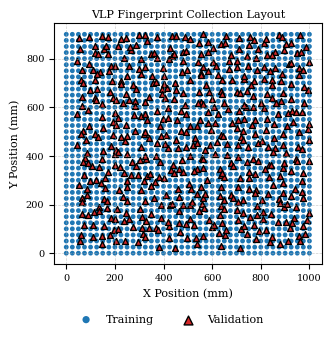

In [13]:
import matplotlib.pyplot as plt
import matplotlib

matplotlib.rcParams.update({
    "font.family": "serif",
    "font.size": 8,
    "axes.labelsize": 8,
    "axes.titlesize": 8,
    "legend.fontsize": 8,
    "xtick.labelsize": 7,
    "ytick.labelsize": 7,
    "pdf.fonttype": 42,
    "ps.fonttype": 42
})

fig, ax = plt.subplots(figsize=(3.5, 3))  # IEEE single-column width

# Scatter plots with clearly distinguishable styles
ax.scatter(y_train[:, 0], y_train[:, 1],
           label='Training', marker='o', s=12, c='#1f77b4', edgecolors='none')
ax.scatter(y_valid[:, 0], y_valid[:, 1],
           label='Validation', marker='^', s=18, c='#d62728', edgecolors='k')

ax.set_aspect('equal', adjustable='box')
ax.set_xlabel('X Position (mm)')
ax.set_ylabel('Y Position (mm)')
ax.set_title('VLP Fingerprint Collection Layout', pad=4)

ax.grid(True, linestyle='--', linewidth=0.5, alpha=0.6)

# ✅ Place legend below the plot, centered
fig.legend(loc='upper center',
           bbox_to_anchor=(0.5, -0.001),
           ncol=2,
           frameon=False,
           markerscale=1.5)

plt.tight_layout(pad=0.5)

plt.savefig(FIGURES_DIR / 'methodology-CNC_fingerprint.png', dpi=300, bbox_inches='tight')


## Plot RSS curves

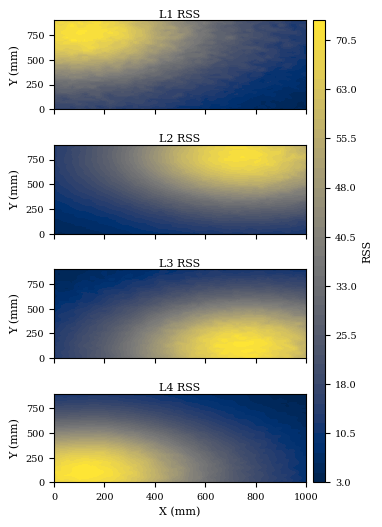

In [58]:
fig = p.plot_rss_contours(train_df)
fig.savefig(FIGURES_DIR/'methodology-CNC_3d_rss_plot.png')

## Assess model perfomance

In [ ]:
import robot_vlp.modeling.gen_cnc_vlp_model as vlp
vlp_models = vlp.load_vlp_models()
vlp_mod = vlp_models['high_acc'] 
pre = vlp_mod.predict(X_valid)
errs = np.sqrt(np.square(pre[:, 0] - y_valid[:, 0]) + np.square(pre[:, 1] - y_valid[:, 1]))

 1/17 ━━━━━━━━━━━━━━━━━━━━ 1s 93ms/step

/Users/tyrelglass/miniforge3/envs/robot-vlp/lib/python3.10/site-packages/sklearn/base.py:493: UserWarning: X does not have valid feature names, but StandardScaler was fitted with feature names
  warnings.warn(


17/17 ━━━━━━━━━━━━━━━━━━━━ 0s 7ms/step


(20.537785274966073, 11.800150448061242)

In [97]:

# Euclidean errors
errs = np.sqrt(np.square(pre[:, 0] - y_valid[:, 0]) + np.square(pre[:, 1] - y_valid[:, 1]))

# Metrics
mean_err = np.mean(errs)
std_err = np.std(errs)
median_err = np.median(errs)
p90_err = np.percentile(errs, 90)
max_err = np.max(errs)
rmse = np.sqrt(np.mean(errs**2))

print(f"Mean Error:   {mean_err:.2f} mm")
print(f"Std Dev:      {std_err:.2f} mm")
print(f"Median Error: {median_err:.2f} mm")
print(f"90th %ile:    {p90_err:.2f} mm")
print(f"Max Error:    {max_err:.2f} mm")
print(f"RMSE:         {rmse:.2f} mm")



Mean Error:   20.54 mm
Std Dev:      11.80 mm
Median Error: 18.80 mm
90th %ile:    34.62 mm
Max Error:    81.64 mm
RMSE:         23.69 mm


In [95]:
errs.mean(), errs.std()

(20.537785274966073, 11.800150448061242)

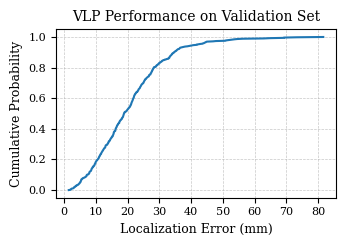

In [98]:
import numpy as np
import matplotlib.pyplot as plt

plt.figure(figsize=(3.5, 2.5))  # Column width for IEEE
sorted_errs = np.sort(errs)
cdf = np.linspace(0, 1, len(sorted_errs))

plt.plot(sorted_errs, cdf, linewidth=1.5)
plt.xlabel('Localization Error (mm)', fontsize=9)
plt.ylabel('Cumulative Probability', fontsize=9)
plt.title('VLP Performance on Validation Set', fontsize=10)
plt.grid(True, linestyle='--', linewidth=0.5, alpha=0.7)

plt.xticks(fontsize=8)
plt.yticks(fontsize=8)
plt.tight_layout()

plt.savefig(FIGURES_DIR / 'methodology-CNC_validation_errors.png', dpi=300)
plt.show()
